In [56]:
from netCDF4 import Dataset                     # Read / Write NetCDF4 files
import matplotlib.pyplot as plt                 # Plotting library
from datetime import datetime                   # Basic Dates and time types
import cartopy, cartopy.crs as ccrs             # Plot maps
import os                                       # Miscellaneous operating system interfaces
from osgeo import osr                           # Python bindings for GDAL
from osgeo import gdal                          # Python bindings for GDAL
import numpy as np                              # Scientific computing with Python

def plot_derived_instability_index(input_folder, output_folder, file_name, var, extent):

    # Open the file
    img = gdal.Open(f'NETCDF:{input_folder}{file_name}:' + var)

    # Read the header metadata
    metadata = img.GetMetadata()
    scale = float(metadata.get(var + '#scale_factor'))
    offset = float(metadata.get(var + '#add_offset'))
    undef = float(metadata.get(var + '#_FillValue'))
    dtime = metadata.get('NC_GLOBAL#time_coverage_start')

    print(f'scale/offset/undef/dtime: {scale}/{offset}/{undef}/{dtime}')

    # Load the data
    ds = img.ReadAsArray(0, 0, img.RasterXSize, img.RasterYSize).astype(float)

    # Apply the scale, offset and convert to celsius
    ds = (ds * scale + offset)

    # Read the original file projection and configure the output projection
    source_prj = osr.SpatialReference()
    source_prj.ImportFromProj4(img.GetProjectionRef())

    target_prj = osr.SpatialReference()
    target_prj.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

    # Reproject the data
    GeoT = img.GetGeoTransform()
    driver = gdal.GetDriverByName('MEM')
    raw = driver.Create('raw', ds.shape[0], ds.shape[1], 1, gdal.GDT_Float32)
    raw.SetGeoTransform(GeoT)
    raw.GetRasterBand(1).WriteArray(ds)

    # Define the parameters of the output file
    options = gdal.WarpOptions(format = 'netCDF',
            srcSRS = source_prj,
            dstSRS = target_prj,
            outputBounds = (extent[0], extent[3], extent[2], extent[1]),
            outputBoundsSRS = target_prj,
            outputType = gdal.GDT_Float32,
            srcNodata = undef,
            dstNodata = 'nan',
            xRes = 0.02,
            yRes = 0.02,
            resampleAlg = gdal.GRA_NearestNeighbour)

    print(options)

    # Write the reprojected file on disk
    temp = file_name[0:-3]
    temp = f'{output_folder}{temp}_reprojected.nc'
    print(temp)
    gdal.Warp(f'{temp}', raw, options=options)
    #-----------------------------------------------------------------------------------------------------------
    # Open the reprojected GOES-R image
    file = Dataset(f'{temp}')

    print(f'file.variables = {file.variables}')

    # Get the pixel values
    data = file.variables['Band1'][:]

    #-----------------------------------------------------------------------------------------------------------
    # Choose the plot size (width x height, in inches)
    plt.figure(figsize=(10,10))

    # Use the Geostationary projection in cartopy
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Define the image extent
    img_extent = [extent[0], extent[2], extent[1], extent[3]]

    # Define the color scale based on the channel
    colormap = "jet" # White to black for IR channels
    # colormap = "gray_r" # White to black for IR channels

    # Plot the image
    img = ax.imshow(data, origin='upper', extent=img_extent, cmap=colormap)

    # Add coastlines, borders and gridlines
    ax.coastlines(resolution='10m', color='black', linewidth=0.8)
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                        color='gray', 
                        alpha=1.0, 
                        linestyle='--', 
                        linewidth=0.25, 
                        xlocs=np.arange(-180, 180, 5), 
                        ylocs=np.arange(-90, 90, 5), 
                        draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

    # Add a colorbar
    plt.colorbar(img, label=var, extend='both', orientation='horizontal', pad=0.05, fraction=0.05)

    # Extract date
    date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))

    # Add a title
    plt.title('GOES-16 ' + var + ' ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC', fontweight='bold', fontsize=10, loc='left')
    plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')


    #-----------------------------------------------------------------------------------------------------------
    # Save the image
    temp = file_name[0:-3]
    plt.savefig(f'{output_folder}{temp}_{var}.png', bbox_inches='tight', pad_inches=0, dpi=300)

    # Show the image
#     plt.show()

scale/offset/undef/dtime: 0.076300927/0.0/65535.0/2022-09-11T00:00:20.4Z
(<osgeo.gdal.GDALWarpAppOptions; proxy of <Swig Object of type 'GDALWarpAppOptions *' at 0x7ff58817cdb0> >, None, None)
./goes16_dsif/ABI-L2-DSIF_2022_09_11_00_00_reprojected.nc
file.variables = {'Band1': <class 'netCDF4._netCDF4.Variable'>
float32 Band1(lat, lon)
    long_name: GDAL Band Number 1
    _FillValue: nan
    grid_mapping: crs
unlimited dimensions: 
current shape = (1000, 1450)
filling on, 'crs': <class 'netCDF4._netCDF4.Variable'>
|S1 crs()
    grid_mapping_name: latitude_longitude
    long_name: CRS definition
    longitude_of_prime_meridian: 0.0
    semi_major_axis: 6378137.0
    inverse_flattening: 298.257223563
    spatial_ref: GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NOR

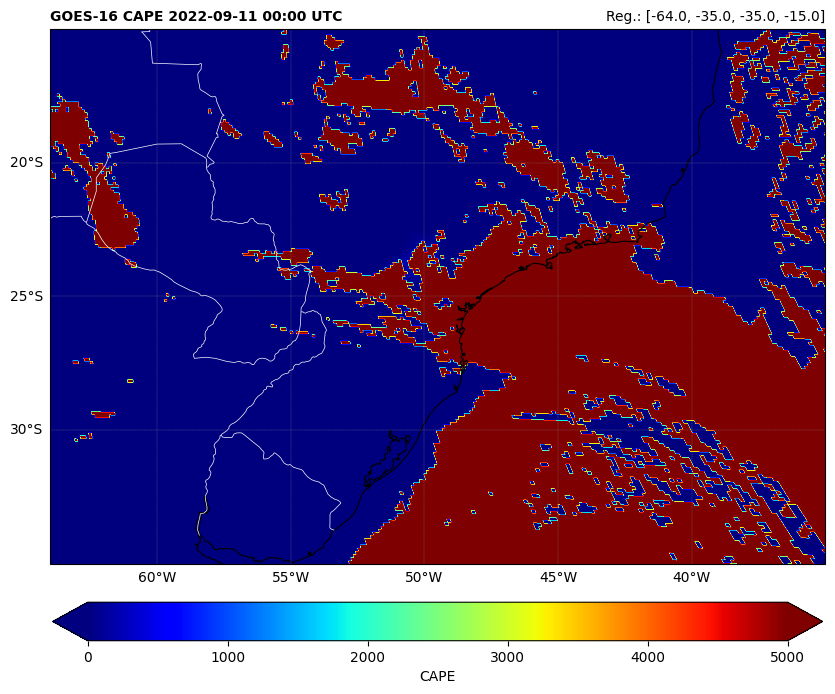

In [46]:
# Desired extent
extent = [-64.0, -35.0, -35.0, -15.0] # Min lon, Min lat, Max lon, Max lat
# extent = [-44.0, -23.0, -43.0, -22.0]  # Min lon, Min lat, Max lon, Max lat --> Rio de Janeiro

# Options:
# - Convective Available Potential Energy (CAPE)
# - Lifted Index (LI)
# - Total Totals (TT)
# - Showalter Index (SI)
# - K-index (KI)
var = 'CAPE'

# Downloaded file
# file_name = 'OR_ABI-L2-DSIF-M6_G16_s20220911700205_e20220911709513_c20220911711480'
file_name = './goes16_dsif/ABI-L2-DSIF_2022_09_11_00_00.nc'

plot_derived_instability_index(file_name, var, extent)

In [1]:
import boto3
import botocore
from botocore import UNSIGNED            # boto3 config
from botocore.config import Config       # boto3 config

from datetime import datetime, timedelta

def download_goes16_product(product_name, date_str, save_path="."):
    # Convert date string to datetime object
    date_obj = datetime.strptime(date_str, "%Y%m%d")

    yyyymmddhh = date_str
    year = datetime.strptime(yyyymmddhh, '%Y%m%d').strftime('%Y')
    day_of_year = datetime.strptime(yyyymmddhh, '%Y%m%d').strftime('%j')

    satellite = "noaa-goes16"

    # Create an S3 client
    s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

    # Generate the prefix based on the date
    prefix = f'{product_name}/{year}/{day_of_year}'
    print(f'prefix: {prefix}')
    
    # List objects in the specified S3 bucket and prefix
    try:
        response = s3_client.list_objects_v2(Bucket="noaa-goes16", Prefix=prefix, )

        if 'Contents' not in response:
            # There are no files
            print(f'No files found for the date: {date_str}, Product: {product_name}')
            return -1
        else:
            # Download each file
            for content in response.get("Contents", []):
                key = content["Key"]
                print(f'key: {key}')

                # Find the index (within the key) in which the date information begins, and extract the date part
                s_index = key.find('s')
                temp = key[s_index+1: -1]
                underline_index = temp.find('_')
                date_string = temp[0: underline_index-3]

                print(date_string)

                # Parse the date string
                parsed_date = datetime.strptime(date_string, '%Y%j%H%M')

                # Format the parsed date as YYYYMMDDHM
                formatted_date = parsed_date.strftime('%Y_%m_%d_%H_%M')

                print(formatted_date)

                local_path = f"{save_path}/{product_name}_{formatted_date}.nc"

                print(f"Downloading {key} to {local_path}")
                s3_client.download_file("noaa-goes16", key, local_path)

            print("Download complete!")

    except botocore.exceptions.NoCredentialsError:
        print("Credentials not available. Please configure AWS credentials.")

In [5]:
if __name__ == "__main__":
    # Specify the date in YYYYMMDD format
    # target_date = "20231124"
    target_date = "20220911"

    # Specify the local path to save the downloaded files
    local_save_path = "../data/goes16/goes16_dsif"

    # product_name = "ABI-L2-TPWF"
    product_name = "ABI-L2-DSIF"
    download_goes16_product(product_name, target_date, local_save_path)

    extent = [-64.0, -35.0, -35.0, -15.0] # Min lon, Min lat, Max lon, Max lat

prefix: ABI-L2-DSIF/2022/254
key: ABI-L2-DSIF/2022/254/00/OR_ABI-L2-DSIF-M6_G16_s20222540000204_e20222540009512_c20222540012162.nc
20222540000
2022_09_11_00_00
key: ABI-L2-DSIF/2022/254/00/OR_ABI-L2-DSIF-M6_G16_s20222540010204_e20222540019512_c20222540022165.nc
20222540010
2022_09_11_00_10
key: ABI-L2-DSIF/2022/254/00/OR_ABI-L2-DSIF-M6_G16_s20222540020204_e20222540029512_c20222540032062.nc
20222540020
2022_09_11_00_20
key: ABI-L2-DSIF/2022/254/00/OR_ABI-L2-DSIF-M6_G16_s20222540030204_e20222540039512_c20222540042190.nc
20222540030
2022_09_11_00_30
key: ABI-L2-DSIF/2022/254/00/OR_ABI-L2-DSIF-M6_G16_s20222540040204_e20222540049512_c20222540052034.nc
20222540040
2022_09_11_00_40


KeyboardInterrupt: 

scale/offset/undef/dtime: 0.0015718/-43.0/65535.0/2022-09-11T16:40:20.6Z
(<osgeo.gdal.GDALWarpAppOptions; proxy of <Swig Object of type 'GDALWarpAppOptions *' at 0x7ff516b2b900> >, None, None)
./goes16_dsif_imgs/ABI-L2-DSIF_2022_09_11_16_40_reprojected.nc
file.variables = {'Band1': <class 'netCDF4._netCDF4.Variable'>
float32 Band1(lat, lon)
    long_name: GDAL Band Number 1
    _FillValue: nan
    grid_mapping: crs
unlimited dimensions: 
current shape = (1000, 1450)
filling on, 'crs': <class 'netCDF4._netCDF4.Variable'>
|S1 crs()
    grid_mapping_name: latitude_longitude
    long_name: CRS definition
    longitude_of_prime_meridian: 0.0
    semi_major_axis: 6378137.0
    inverse_flattening: 298.257223563
    spatial_ref: GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude

KeyboardInterrupt: 

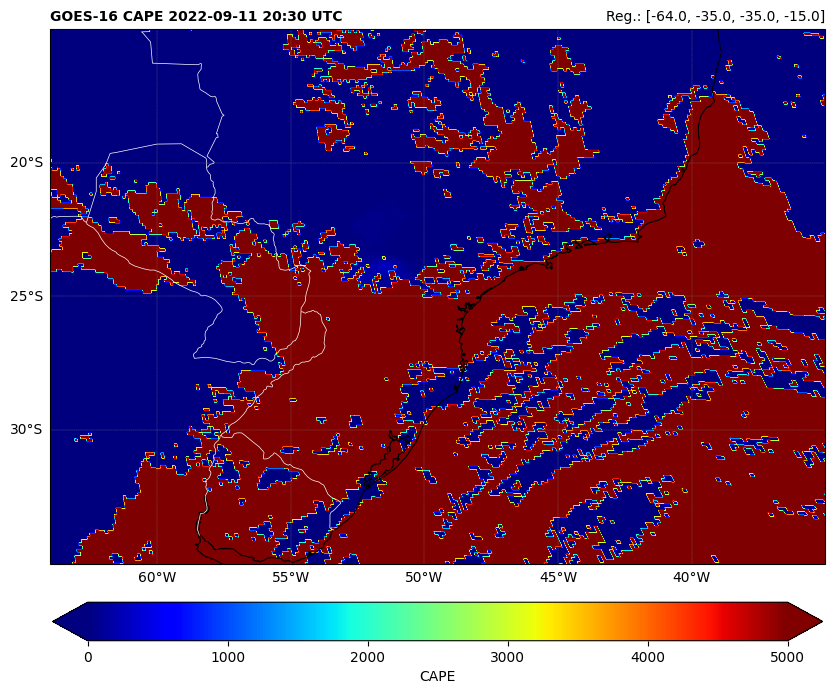

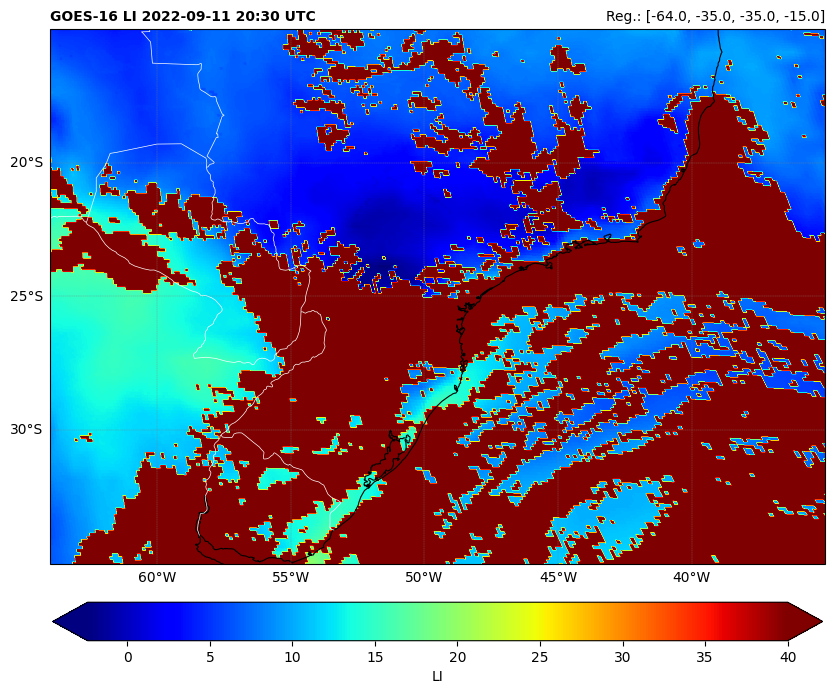

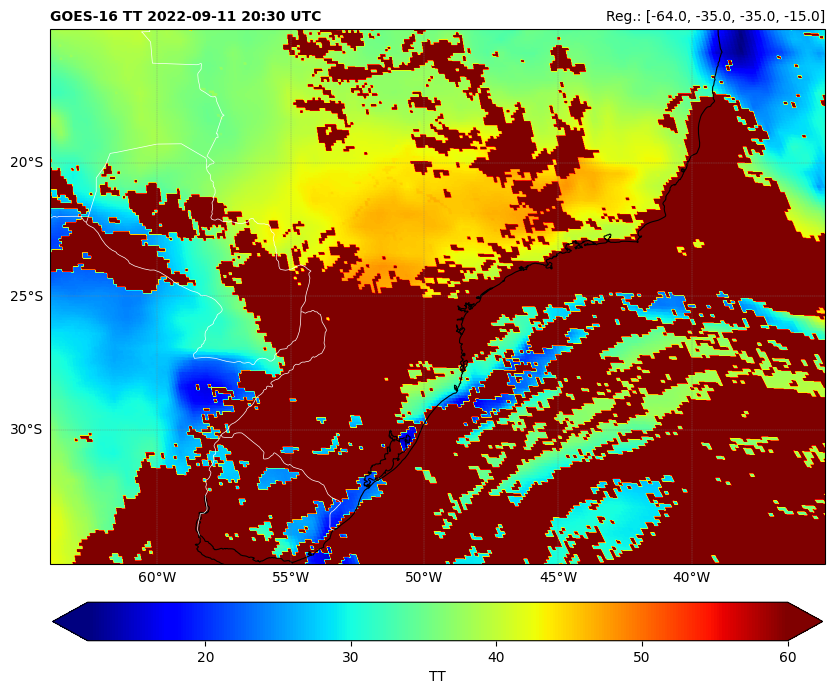

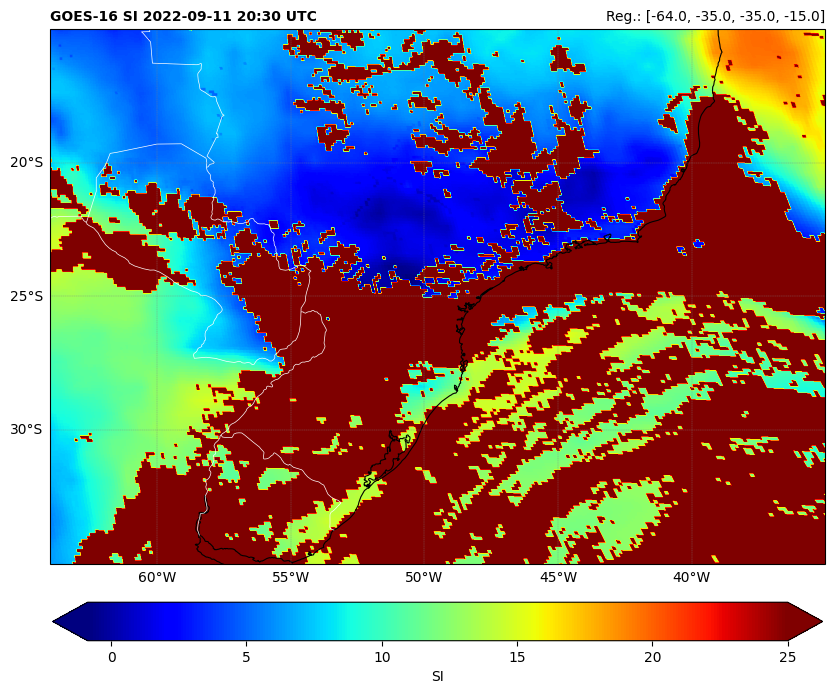

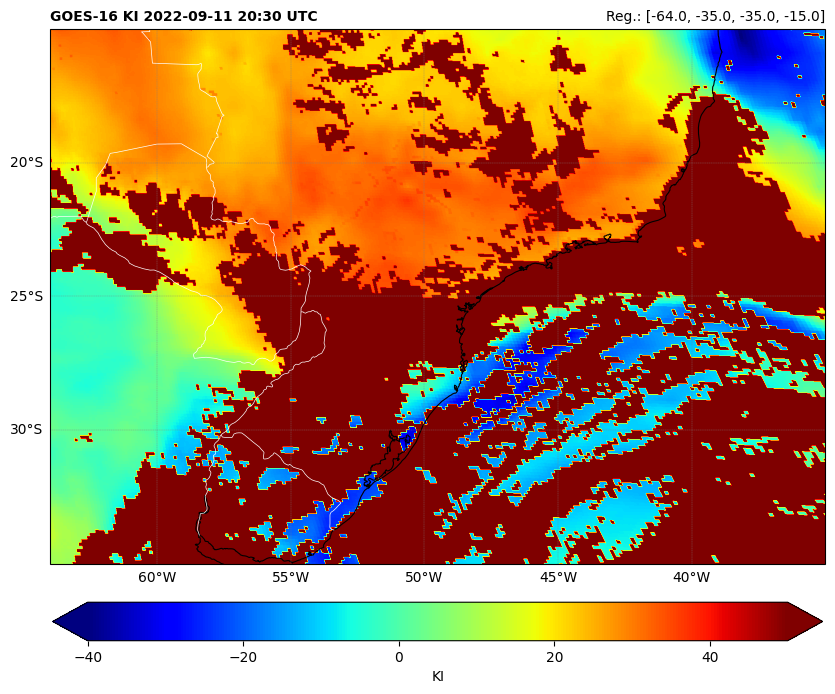

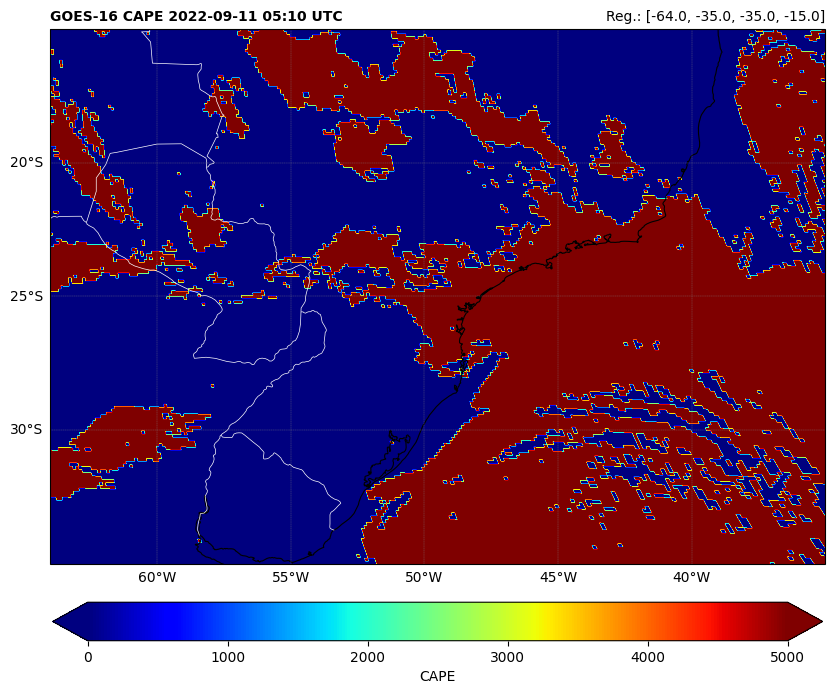

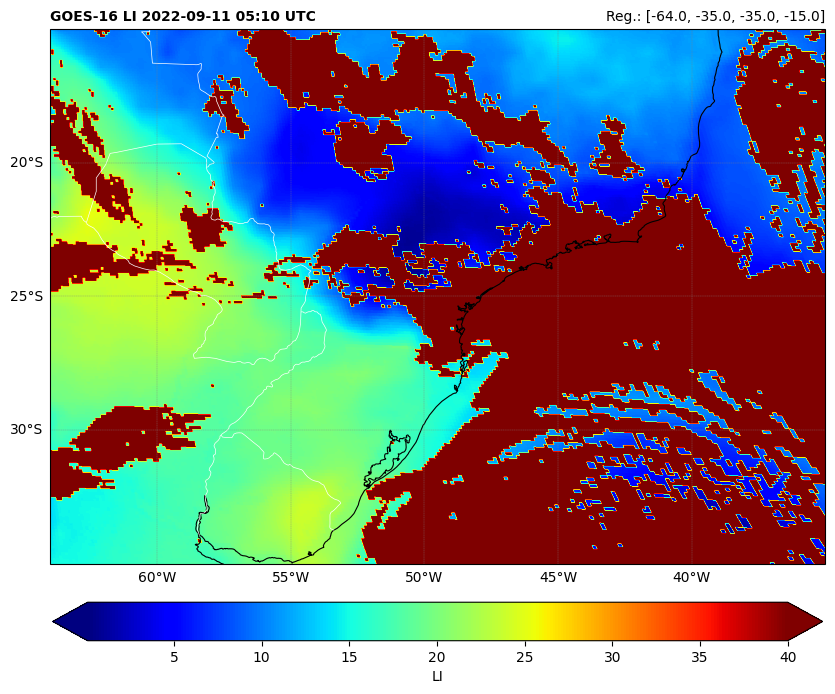

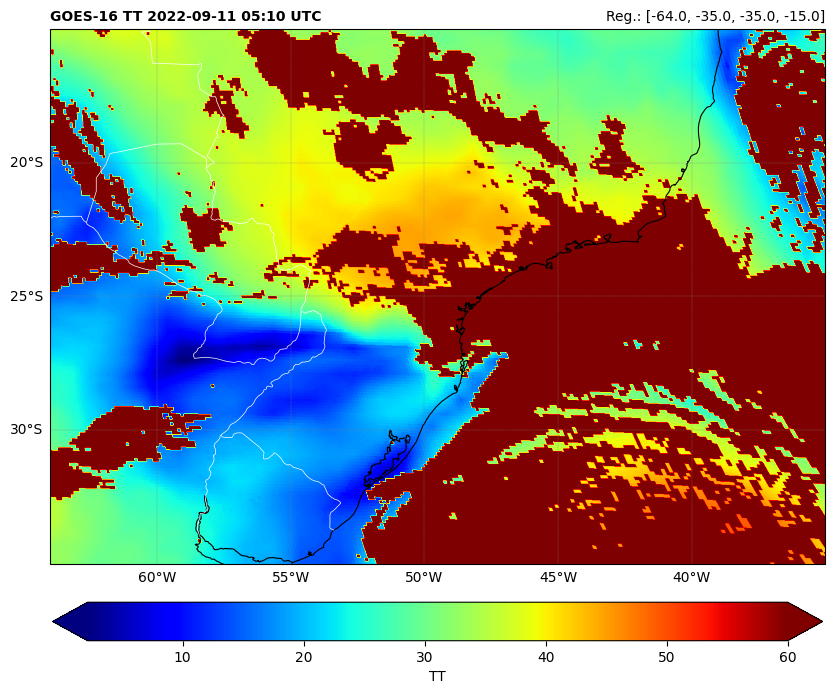

In [60]:
import os

input_folder = './goes16_dsif/'

# Get the list of file names in the folder
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

extent = [-64.0, -35.0, -35.0, -15.0] # Min lon, Min lat, Max lon, Max lat

# Options:
# - Convective Available Potential Energy (CAPE)
# - Lifted Index (LI)
# - Total Totals (TT)
# - Showalter Index (SI)
# - K-index (KI)
vars = ['CAPE', 'LI', 'TT', 'SI', 'KI']

# Print the list of file names
print(file_names)

output_folder = './goes16_dsif_imgs/'

for file_name in file_names:
    for var in vars:
        plot_derived_instability_index(input_folder, output_folder, file_name, var, extent)